In [62]:
import os
import numpy as np
import pandas as pd
import time
import warnings
from matplotlib import pyplot as plt

from sklearn.neural_network import MLPClassifier
import sklearn.metrics
from sklearn.metrics import balanced_accuracy_score


### Data Preprocessing

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


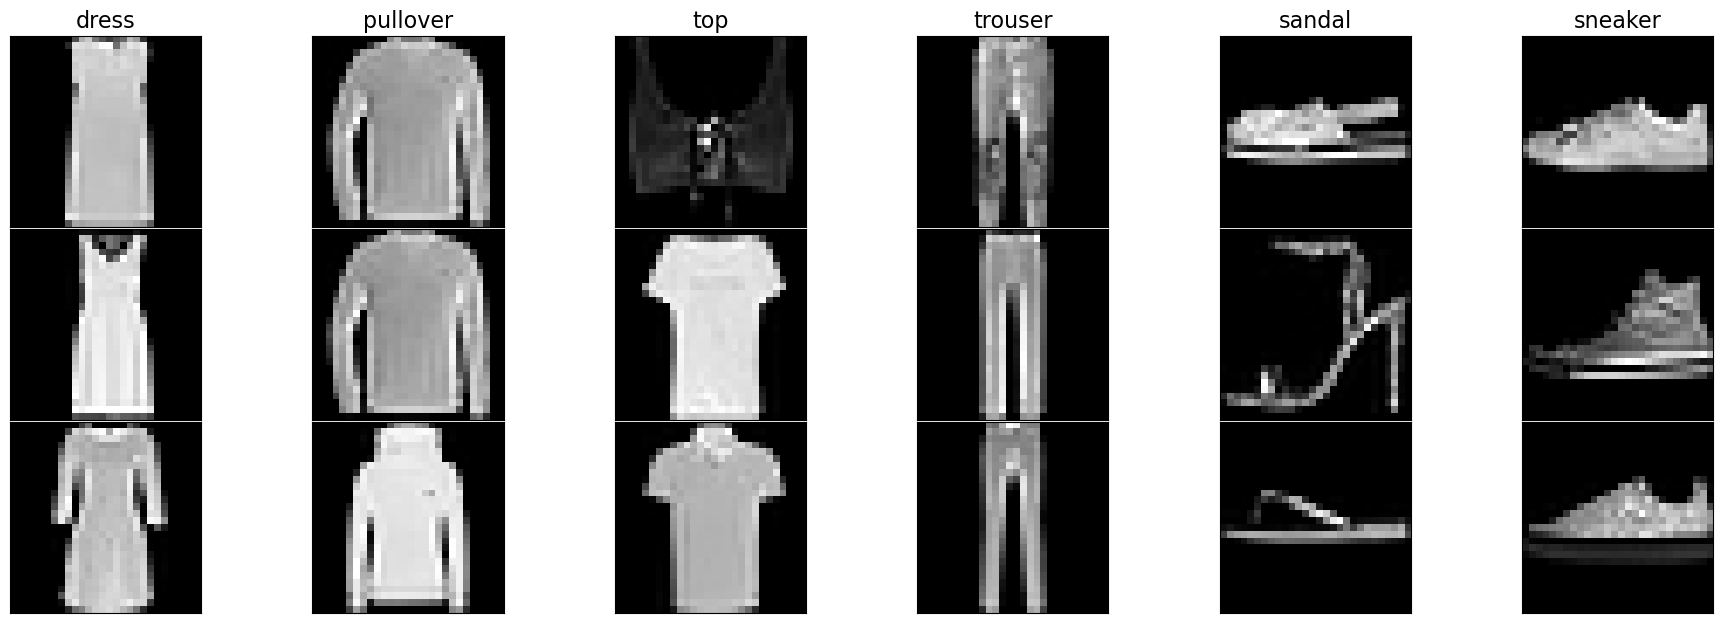

In [2]:
%run load_and_plot_data.py

In [3]:
train_y_df, valid_y_df

(     class_name  class_uid
 0      pullover          2
 1           top          0
 2         dress          3
 3        sandal          5
 4      pullover          2
 ...         ...        ...
 2097     sandal          5
 2098     sandal          5
 2099     sandal          5
 2100     sandal          5
 2101     sandal          5
 
 [2102 rows x 2 columns],
     class_name  class_uid
 0        dress          3
 1        dress          3
 2        dress          3
 3        dress          3
 4        dress          3
 ..         ...        ...
 595    sneaker          7
 596    sneaker          7
 597        top          0
 598        top          0
 599    trouser          1
 
 [600 rows x 2 columns])

In [4]:
temp = np.array(train_y_df)
count_array = temp[:,1]
count_train = np.unique(count_array, return_counts = True)

temp = np.array(valid_y_df)
count_array = temp[:,1]
count_valid = np.unique(count_array, return_counts = True)

In [5]:
count_train, count_valid

((array([0, 1, 2, 3, 5, 7], dtype=object),
  array([  1,   1, 100, 400, 800, 800])),
 (array([0, 1, 2, 3, 5, 7], dtype=object),
  array([100, 100, 100, 100, 100, 100])))

In [6]:
train_y = np.array(train_y_df['class_uid'])
train_y

array([2, 0, 3, ..., 5, 5, 5])

In [7]:
train_x.shape, train_x[0].dtype

((2102, 784), dtype('int64'))

In [8]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(train_x)
normed_train_x = scaler.transform(train_x)
normed_train_x.shape

(2102, 784)

In [9]:
mlp = MLPClassifier(
            activation='relu',
            solver='lbfgs',
            learning_rate='adaptive', 
            momentum=0.0,
            tol=1e-5,
            )

In [10]:
mlp_hyperparameter_grid = dict(
    hidden_layer_sizes = [(32, )], #[(16,), (32,), (64,)],
    max_iter= [1000], #[64, 128, 1000],
    random_state = [101, 111, 123, 321, 121, 212, 213, 312],
    batch_size= [32], 
    learning_rate_init= [0.001], 
    n_iter_no_change=[10], #[10, 25, 50],
    alpha=[10, 1e0, 1e-1, 1e-2, 1e-3]
    )

In [11]:
valid_y = np.array(valid_y_df['class_uid'])
valid_y.shape

(600,)

### fit on train

In [12]:
### splitter
valid_indicators_L = np.hstack([
    -1 * np.ones(int(0.8 * train_y.size)), # -1 means never include this example in any test split
    0  * np.ones(train_y.size - int(0.8 * train_y.size)), #  0 means include in the first test split (we count starting at 0 in python)
    ])
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_L)

In [13]:
mlp_searcher = sklearn.model_selection.GridSearchCV(estimator = mlp,
                                                    param_grid = mlp_hyperparameter_grid,
                                                    scoring = 'balanced_accuracy',
                                                    cv = my_splitter,
                                                    return_train_score = True,
                                                    refit=False
                                                   )

In [14]:
start_time_sec = time.time()
mlp_searcher.fit(normed_train_x, train_y)
elapsed_time_sec = time.time() - start_time_sec

/Users/richardwang/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/richardwang/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/richardwang/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

In [15]:
mlp_searcher_result = pd.DataFrame(mlp_searcher.cv_results_).copy()
mlp_searcher_result.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'param_batch_size', 'param_hidden_layer_sizes',
       'param_learning_rate_init', 'param_max_iter', 'param_n_iter_no_change',
       'param_random_state', 'params', 'split0_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [16]:
# plot hyperparameter search result
balanced_accuracy_score = mlp_searcher_result.mean_test_score
alpha_list = mlp_searcher_result.param_alpha
random_seeds = mlp_searcher_result.param_random_state

# alpha_list, balanced_accuracy_score, random_seeds

In [17]:
# alpha_list= np.split(np.array(alpha_list),7)
# balanced_accuracy_score = np.split(np.array(balanced_accuracy_score), 7)
# balanced_accuracy_score.shape

In [45]:
colors = ['black', 'b', 'g', 'y', 'magenta', 'pink', 'grey', 'brown']
log_alpha_list = alpha_list.copy()
for i in range(len(alpha_list)):
    # print(alpha_list[i])
    # print(np.log10(alpha_list[i]))
    log_alpha_list[i] = np.log10(alpha_list[i])

# log_alpha_list

In [46]:
log_alphas = np.zeros((8,5))
BAccs = np.zeros((8,5))

for i in range(len(np.unique(alpha_list))): # 5
    for j in range(len(np.unique(random_seeds))): #4
        # plt.plot(log_alpha_list[i*len(np.unique(random_seeds)) + j], balanced_accuracy_score[i*len(np.unique(random_seeds)) + j], marker='o', linestyle='-', color=colors[j])
        log_alphas[j,i] = log_alpha_list[i*len(np.unique(random_seeds)) + j]
        BAccs[j,i] = balanced_accuracy_score[i*len(np.unique(random_seeds)) + j]

log_alphas.shape, BAccs.shape

((8, 5), (8, 5))

In [57]:
mean_BAccs = []
for i in range(log_alphas.shape[1]):
    # print(log_alphas[:,i])
    mean_BAccs.append(np.mean(BAccs[:,i]))

mean_BAccs = np.array(mean_BAccs[::-1])
mean_BAccs.shape

(5,)

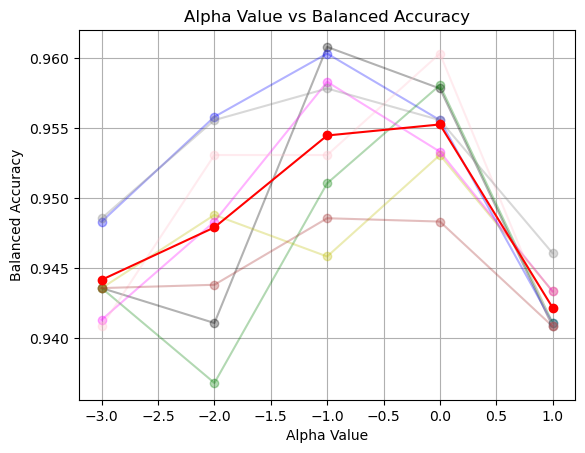

((8, 5), (8, 5))

In [58]:
for m in range(len(np.unique(random_seeds))):    
    plt.plot(log_alphas[m], BAccs[m], marker='o', linestyle='-', color=colors[m], alpha=0.3)

plt.plot(np.unique(log_alphas), mean_BAccs, marker='o', linestyle='-', color='red')
    
plt.title('Alpha Value vs Balanced Accuracy')
plt.xlabel('Alpha Value')
plt.ylabel('Balanced Accuracy')
plt.grid(True)
plt.show()
log_alphas.shape, BAccs.shape

In [59]:
mlp_searcher.best_params_

{'alpha': 0.1,
 'batch_size': 32,
 'hidden_layer_sizes': (32,),
 'learning_rate_init': 0.001,
 'max_iter': 1000,
 'n_iter_no_change': 10,
 'random_state': 101}

In [60]:
best_mlp = mlp # TODO call set_params using the best_params_ found by your searcher
best_param = mlp_searcher.best_params_
best_mlp.set_params(**best_param)
best_mlp.fit(normed_train_x, train_y)

MLPClassifier(alpha=0.1, batch_size=32, hidden_layer_sizes=(32,),
              learning_rate='adaptive', max_iter=1000, momentum=0.0,
              random_state=101, solver='lbfgs', tol=1e-05)

In [63]:
normed_valid_x = scaler.transform(valid_x)
pred_y = best_mlp.predict(normed_valid_x)
best_mlp_BAcc = balanced_accuracy_score(pred_y, valid_y)
best_mlp_BAcc

/Users/richardwang/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.8230207086818861

In [119]:
# for i in range(len(np.unique(alpha_list))): # 5
#     for j in range(len(np.unique(random_seeds))): #4
#         plt.plot(log_alpha_list[i*4 + j], balanced_accuracy_score[i*4 + j], marker='o', linestyle='-', color=colors[j])
        
# plt.title('Alpha Value vs Balanced Accuracy')
# plt.xlabel('Alpha Value')
# plt.ylabel('Balanced Accuracy')
# plt.grid(True)
# plt.show()